# List 2

In [1]:
from datetime import timedelta, date
from matplotlib.animation import FuncAnimation
import imaplib
from pydantic_settings import BaseSettings,SettingsConfigDict
from emails.gmail import  GmailIMAP
from emails.model import  Response
from typing import Any
from functools import lru_cache
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import calendar
import networkx as nx
from utils import with_pickle

In [2]:
class UserAuth(BaseSettings):
    model_config = SettingsConfigDict(frozen=True, env_file=".env", env_prefix="gmail_")
    
    user: str
    password: str
    imap_url: str = "imap.gmail.com"
    
    @property
    def connection(self):
        return imaplib.IMAP4_SSL(self.imap_url) 
    

In [3]:
USER_AUTH = UserAuth()

In [4]:
def get_message_count(manager: GmailIMAP) -> int:
    resp = manager.select("INBOX")
    if not resp.ok:
        raise SystemExit("Cannot open INBOX")
    return resp.message_count

In [5]:
@lru_cache(maxsize=1)
def get_messages(manager: GmailIMAP, count: int = 100, batch_size: int = 20):
    messages = []
    messages_no = min(count, get_message_count(manager))
    fails_coutner = 0
    print(f"Messages to read: {messages_no}.")
    for i in range (1, messages_no + 1, batch_size):
        responses = manager.fetch_messages(range(i, i + batch_size))
        for resp in responses:
            if resp.ok and resp.message:
                messages.append(resp)
            else:
                fails_coutner += 1
    print(f"Successfully read {len(messages)}.")
    print(f"Fails with {fails_coutner}.")
    return messages

# Frequency analysis

In [6]:
def analyze_freq_pattern(manager: GmailIMAP, message_max_limit: int = 100, batch_size: int = 100):
    messages = get_messages(manager, message_max_limit, batch_size)
    dates = pl.DataFrame({"Time": [m.message.date for m in messages]})
    return dates


In [7]:
%%time
MAILS_TO_DOWNLOAD = 1000 
BATCH_SIZE = 100
imap = GmailIMAP(USER_AUTH.user, USER_AUTH.password)
dates = analyze_freq_pattern(imap, MAILS_TO_DOWNLOAD, BATCH_SIZE)
imap.conn.logout()

Messages to read: 1000.
CPU times: user 2.03 s, sys: 250 ms, total: 2.28 s
Wall time: 3min 45s


KeyboardInterrupt: 

In [8]:
is_written: bool = True
if not is_written: 
    with Path("data/dates.pkl").open("wb") as f:
        pickle.dump(dates, f)
else:
    with Path("data/dates.pkl").open("rb") as f:
        dates = pickle.load(f)

In [9]:
# daily_hist = (
#     dates
#     .with_columns(pl.col("Time").dt.truncate("1d").alias("day"))
#     .group_by("day")
#     .agg(pl.len().alias("count"))
#     .sort("day")
# )

daily_hist = (
    dates
    .sort("Time")
    .group_by_dynamic(
        index_column="Time",
        every="1d",
        closed="left"
    )
    .agg(pl.len().alias("count"))
)

daily_pattern = (
    dates
    .with_columns(pl.col("Time").dt.hour().alias("hour"))
    .group_by("hour")
    .agg(pl.len().alias("count"))
    .sort("hour")
)

monthly_pattern = (
    dates
    .with_columns(pl.col("Time").dt.month().alias("month"))
    .group_by("month")
    .agg(pl.len().alias("count"))
    .sort("month")
)


weekly_pattern = (
    dates
    .with_columns(pl.col("Time").dt.weekday().alias("day"))
    .group_by("day")
    .agg(pl.len().alias("count"))
    .sort("day")
)
daily_pattern
monthly_pattern

month,count
i8,u32
1,122
2,127
3,155
4,96
5,57
…,…
8,7
9,19
10,153


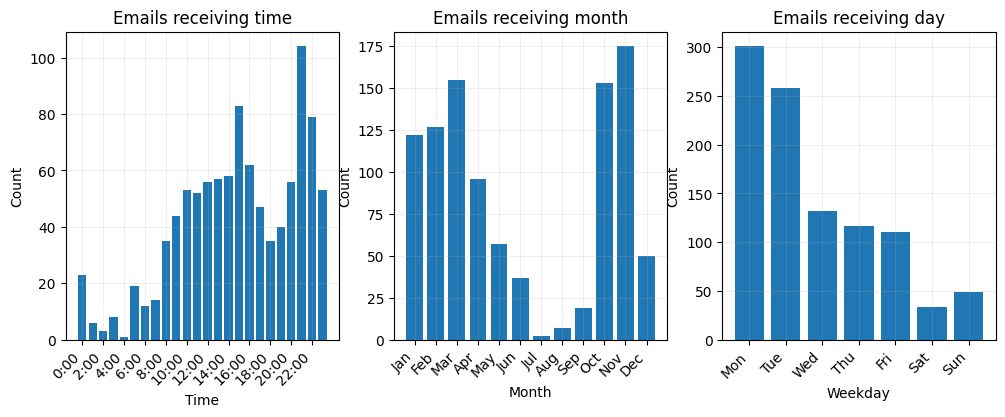

In [10]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
ax = axes.flatten()[0]
ax.bar(daily_pattern["hour"], daily_pattern["count"])
ax.set_xlabel("Time")
ax.set_ylabel("Count")
ax.set_title("Emails receiving time")
ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels((f"{i}:00" for i in range(0, 24, 2)), rotation=45, ha="right")
ax.grid(alpha=0.2)

ax = axes.flatten()[1]
month_names = list(calendar.month_abbr)[1:] # For some reason the first value is an additional empty string
ax.bar(monthly_pattern["month"], monthly_pattern["count"])
ax.set_xlabel("Month")
ax.set_ylabel("Count")
ax.set_title("Emails receiving month")
ax.set_xticks(range(1,13))
ax.set_xticklabels(month_names, rotation=45, ha="right")
ax.grid(alpha=0.2)


ax = axes.flatten()[2]
weekday_names = list(calendar.day_abbr)
ax.bar(weekly_pattern["day"], weekly_pattern["count"])
ax.set_xlabel("Weekday")
ax.set_ylabel("Count")
ax.set_title("Emails receiving day")
ax.set_xticks(range(1,8))
ax.set_xticklabels(weekday_names, rotation=45, ha="right")
ax.grid(alpha=0.2)


In [31]:
daily_volume = (
    daily_hist
    .with_columns(
        pl.col("count").cum_sum().alias("cumulative_count")
    )
)

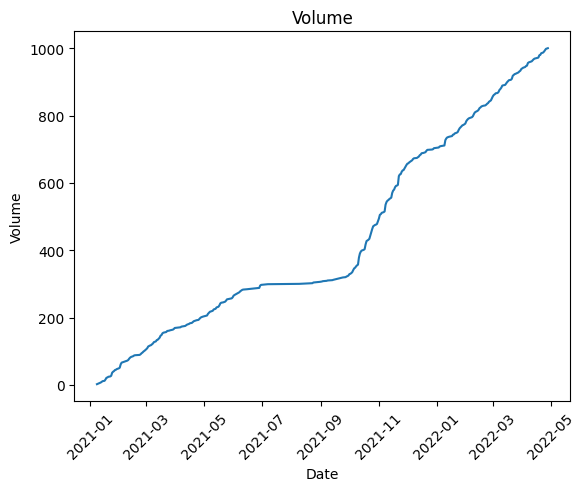

In [32]:

plt.plot(daily_volume["Time"], daily_volume["cumulative_count"])
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume")
plt.xticks(rotation=45)
plt.show()

# Network graph

In [33]:
def get_message_count(manager: GmailIMAP, dir: str) -> int:
    resp = manager.select(dir)
    if not resp.ok:
        msg = f"Cannot open {dir}"
        raise SystemExit(msg)
    return resp.message_count

@with_pickle()
def get_messages(manager: GmailIMAP, limits: tuple[int] = [80], batch_size: int = 20):
    # dirs = ["INBOX"]
    dirs = ["[Gmail]/Wszystkie"]
    if len(limits) != len(dirs):
        msg = "Limits number must corresponds with number of directories."
        raise ValueError(msg)
    dirs_n_limits = zip(dirs, limits, strict=True)
    messages = []
    fails_coutner = 0
    for d, l in dirs_n_limits:
        print(f"Reading from: {d}")
        messages_no = get_message_count(manager, d)
        print(f"Found {messages_no} in total.")
        messages_no = min(messages_no, l)
        print(f"Messages to read: {messages_no}.")
        manager.select(d)
        for i in range (1, messages_no + 1, batch_size):
            responses = manager.fetch_messages(range(i, i + batch_size))
            for resp in responses:
                if resp.ok and resp.message:
                    messages.append(resp)
                else:
                    fails_coutner += 1
    print(f"Successfully read {len(messages)}.")
    print(f"Fails with {fails_coutner}.")
    return messages

In [34]:
import re
email_regex = re.compile(r" *<([^>]+)> *")
def _get_user(text: str) -> str:
    return re.sub(email_regex, "", text)

from itertools import chain
import hashlib
def _get_hash(text: str) -> str:
    return hashlib.sha1(text.encode("utf-8")).hexdigest()[-6:]
# list(chain.from_iterable([["Ania"], ["Bania", "Hania"]]))

In [99]:

def get_senders(manager: GmailIMAP, *args, **kwargs):
    messages = get_messages(manager, *args, **kwargs)
    return pl.DataFrame({
        "Hash" : [_get_hash(m.message.subject) for m in messages],
        "Date" : [m.message.date for m in messages],
        "Sender": [m.message.sender for m in messages],
        "Sender_count": [len(m.message.sender) for m in messages],
        "Receiver": [m.message.to for m in messages],
        "Receiver_count": [len(m.message.to) for m in messages],
        "CC": [m.message.cc for m in messages],
        "CC_count": [len(m.message.cc) for m in messages],
        "BCC": [m.message.bcc for m in messages],
        "BCC_count": [len(m.message.bcc) for m in messages],
    })

def get_relations(senders: pl.DataFrame) -> pl.DataFrame:
    return (
        senders
        .explode("Sender")
        .explode("Receiver")
        .explode("CC")
        .explode("BCC")
        .with_columns([
            pl.when(pl.col("Receiver").str.contains(r"262290|Jankowski"))
            .then(pl.lit("Me"))
            .otherwise(pl.col("Receiver"))
            .alias("Receiver"),
            
            pl.when(pl.col("Sender").str.contains(r"262290|Jankowski"))
            .then(pl.lit("Me"))
            .otherwise(pl.col("Sender"))
            .alias("Sender"),
        ])
        .filter(
            ~pl.col("Receiver").str.contains(r"wielu adresatów")
        )
        # Remove artifacts
        .filter(
            ~(pl.col("Receiver").str.contains(r"Osobka") & pl.col("Sender").str.contains(r"Osobka"))
        )
        .filter(
            ~(pl.col("Receiver").str.contains(r"test-group") & pl.col("Sender").str.contains(r"botdatabase"))
        )
    )

def create_graph(relations: pl.DataFrame) -> nx.Graph:
    unique_relations = relations.unique([pl.col("Sender"), pl.col("Receiver"), pl.col("CC"), pl.col("BCC")])
    unique_relations = unique_relations.filter(pl.col("Receiver").is_not_null())
    print(f"Unique rows: {len(unique_relations)}")
    edges = list(zip(unique_relations["Sender"], unique_relations["Receiver"]))
    from pyvis.network import Network
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw(G, with_labels=False, node_color="lightblue", node_size=15, font_size=12)
    net = Network(
        directed = False,
        select_menu = True,
        filter_menu = True,
    )
    net.show_buttons()
    net.from_nx(G)
    net.save_graph('communicatio_graph.html')
    return G


In [100]:
def filter_by_date(frame: pl.DataFrame, upper_threshold_date: pl.date) -> pl.DataFrame:
    return (
        frame
        .filter(pl.col("Date") < upper_threshold_date)
    )

In [ ]:

def update_graph(g: nx.Graph, relations: pl.DataFrame) -> nx.Graph:
    unique_relations = relations.unique([pl.col("Sender"), pl.col("Receiver"), pl.col("CC"), pl.col("BCC")])
    unique_relations = unique_relations.filter(pl.col("Receiver").is_not_null())
    edges = list(zip(unique_relations["Sender"], unique_relations["Receiver"]))
    g.add_edges_from(edges)
    return g


In [171]:

class Animation:
    def __init__(self) -> None:
        self.graph = None
        self.relations_evolutions = None
                
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        self.fig = fig
        ax.set_title("Network Growth Over Time")
        ax.axis("off")
        self.ax = ax
        
    def update_animation(self, frame_idx):
        self.graph.clear()
        update_graph(self.graph, self.relations_evolutions[frame_idx])

        self.ax.clear()
        self.ax.set_title(f"Network Growth Over Time:\n{frame_idx}")
        self.ax.axis("off")
        
        self.pos = (
            nx.spring_layout(self.graph, seed=42)
            if self.pos == {}
            else
            nx.spring_layout(self.graph, pos=self.pos, seed=42)
        )

        nx.draw_networkx(
            self.graph,
            pos=self.pos,
            ax=self.ax,
            node_color='skyblue',
            edge_color='gray',
            with_labels=False,
            node_size=100,
        )

        
    
    def set_graph(self, g: nx.Graph, relations: list[str]) -> None:
        self.graph = g
        self.pos = nx.spring_layout(self.graph, seed=42)
        self.relations_evolutions = relations
    

    def save_animate(self) -> None:
        anim = FuncAnimation(
            self.fig,
            self.update_animation,
            frames=len(self.relations_evolutions),
            interval=1000,
            blit=False
        )
        anim.save("network_growth.gif", writer="pillow", fps=1)
        print("✅ Saved animation as 'network_growth.gif'")


Unique rows: 2416


('BYE', [b'LOGOUT Requested'])

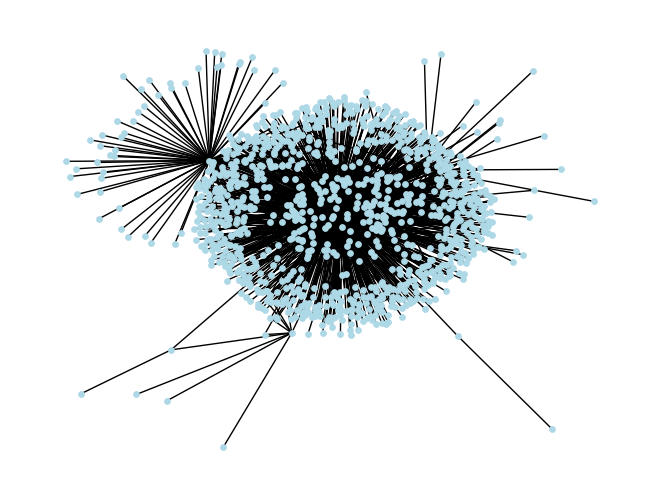

In [48]:
MAILS_TO_DOWNLOAD_COUNT = [6000]
BATCH_SIZE = 200
imap = GmailIMAP(USER_AUTH.user, USER_AUTH.password)
senders = get_senders(imap, MAILS_TO_DOWNLOAD_COUNT, BATCH_SIZE, pickle_path="data/all_mails.pkl")
relations = get_relations(senders)
relations_graph = create_graph(relations)
imap.conn.logout()

Starting building animation...
✅ Saved animation as 'network_growth.gif'


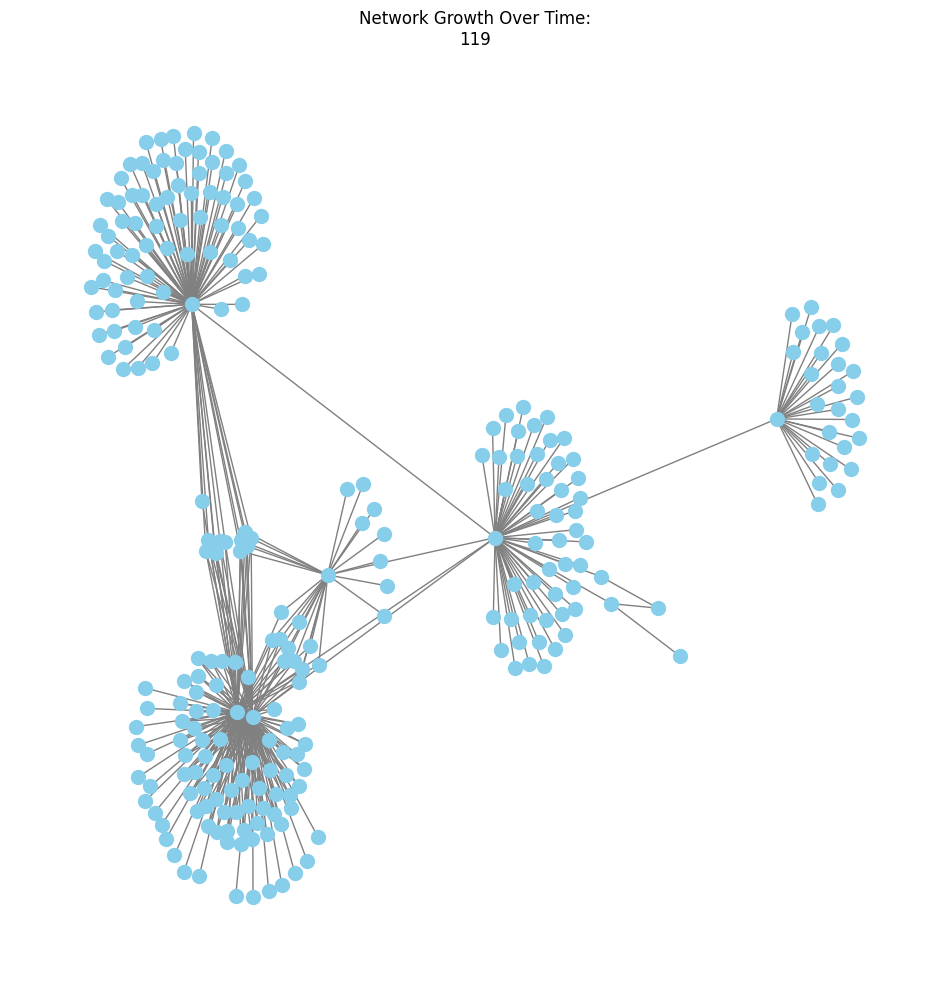

In [172]:

def create_growth_process_graph():
    min_date, max_date = relations["Date"].min().date(), relations["Date"].max().date()
    steps = relations["Date"].dt.date().unique()
    anim_steps = 120
    dates = relations["Date"].dt.date().unique().sort()[:anim_steps]
    # last_step_date = relations["Date"].dt.date().unique().sort()[znim_steps]
    # step_length = (max_date - min_date).days // anim_steps
    # dates = [min_date + timedelta(days=i * step_length) for i in range(anim_steps + 1)]
    g = nx.Graph()
    rel_evolution = [filter_by_date(relations, d) for d in dates]
    anim = Animation()
    anim.set_graph(g, rel_evolution)
    print("Starting building animation...")
    anim.save_animate()
    return g

rel_graph_evolution = create_growth_process_graph()

In [ ]:
def get_g_stats(g: nx.Graph):
    return pl.DataFrame({
        "my_contacts": g.degree["Me"],
        "clustering": nx.average_clustering(g),
        "bc": nx.betweenness_centrality(g)["Me"],
        "radius": nx.radius(g),
        "diameter": nx.diameter(g),
        "top_vs": ",".join([_get_user(k) for k, v in sorted(g.degree(), key=lambda item: item[1], reverse=True)[:3]]),
    })

In [191]:
combined_df = pl.concat([
    relations.filter(pl.col("Receiver") == "Me").select(pl.col("Sender")),
    relations.filter(pl.col("Sender") == "Me").select(pl.col("Receiver").alias("Sender"))
])

combined_df.group_by("Sender").agg(pl.len()).sort("len", descending=True).head(10)


Sender,len
str,u32
"""Medium Daily Digest <noreply@m…",769
"""The Medium Newsletter <newslet…",288
"""edukacja@pwr.edu.pl""",277
"""DataCamp <team@datacamp.com>""",203
"""DataCamp Insights <team@dataca…",183
"""Google Flights <noreply-travel…",155
"""Academia.edu <premium@academia…",150
"""ResearchGate <no-reply@researc…",136
"""JSOS <admin_jsos@pwr.edu.pl>""",111
